In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import time

import json
import random

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Custom model


### Initiate

In [ ]:
# 업비트 학습용 데이터
# 2023년 5월 13일 17시 21분 - 5월 14일 00시 00분 까지의 데이터입니다.
# /content/drive/MyDrive/Colab Notebooks/data/upbit_train_data.json
with open('/content/drive/MyDrive/Colab Notebooks/data/upbit_train_data.json') as file:
    train_data = json.load(file)
    train_data = train_data[::-1]

'''
state : 이전 시세 변화량, 거래량  
state_space : 2

action : 중립, 매수, 매도 
action_space : 3

reward : 매도 시 차익을 리워드로 반환, 잃을 경우 리워드 없음. ( 매수 10, 중립은 5 리워드 )

ex)
  trade_price = 38755000
  next_trade_prive = 38697000

done : 학습 동안 reward를 5만원 이상 벌 경우, 미션에 성공했다고 판단
'''

# Q 테이블 생성
# bins = [이전 시세 증감, 거래량]
def Qtable(state_space,action_space,bin_size = 30):
    
    bins = [np.linspace(-4,4,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

# 이산화 함수
# Q 테이블이 지나치게 방대해 지는 것을 막기 위해 단순화 작업이 반드시 필요합니다.
def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

# 이산화 작업 예
# print(Discrete((-58000, 4.11099952), bins))

[{'candleDateTime': '2023-05-03T17:21:00+00:00', 'candleDateTimeKst': '2023-05-04T02:21:00+09:00', 'openingPrice': 38225000, 'highPrice': 38231000, 'lowPrice': 38195000, 'tradePrice': 38229000, 'candleAccTradeVolume': 1.25646571, 'candleAccTradePrice': 48013478.16814, 'timestamp': 1683134518624, 'code': 'CRIX.UPBIT.KRW-BTC', 'unit': 1}, {'candleDateTime': '2023-05-03T17:22:00+00:00', 'candleDateTimeKst': '2023-05-04T02:22:00+09:00', 'openingPrice': 38229000, 'highPrice': 38231000, 'lowPrice': 38209000, 'tradePrice': 38209000, 'candleAccTradeVolume': 1.82832104, 'candleAccTradePrice': 69884988.02055, 'timestamp': 1683134578780, 'code': 'CRIX.UPBIT.KRW-BTC', 'unit': 1}, {'candleDateTime': '2023-05-03T17:23:00+00:00', 'candleDateTimeKst': '2023-05-04T02:23:00+09:00', 'openingPrice': 38209000, 'highPrice': 38238000, 'lowPrice': 38209000, 'tradePrice': 38238000, 'candleAccTradeVolume': 0.64032611, 'candleAccTradePrice': 24469109.1751, 'timestamp': 1683134638143, 'code': 'CRIX.UPBIT.KRW-BTC'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Q Learning function


In [ ]:
def Q_learning(q_table, bins, episodes = 5000, gamma = 0.95, lr = 0.1, timestep = 5000, epsilon = 0.2):
    rewards = 0
    steps = 0 
    data = {'score' : [0]}
    start = time.time()
    ep = [i for i in range(0,episodes + 1)] 
    
    first_data = []

    # 에피소드 갯수만큼 학습을 반복
    for episode in range(1,episodes+1):
        
        # 초기 값을 넣는다. (5월 13일 17시 21일 state)
        current_state = Discrete([-58000, 4.11099952],bins) # initial observation

        score = 0

        # 0 : 중립, 1 : 매수, 2 : 매도
        last_diff_action = 0
        last_buy_stock = {}
        current_stock = train_data[0]
        done = False # 미사용
        
        temp_start = time.time()

        # 학습 데이터를 처음부터 끝까지 학습
        for index, next_stock in enumerate(train_data):

          if not done:
              steps += 1
              ep_start = time.time()

              # 액션 선택

              # 엡실론-그리디 정책에 따라, 어느 정도 확률로 무작위 액션을 시행
              if np.random.uniform(0,1) < epsilon:
                  # 매수한 상태 (중립 0, 매도 2만 가능)
                  if last_diff_action == 1:
                    action = random.choice([0, 2])
                  # 매도한 상태 (중립 0, 매수 1만 가능)
                  elif last_diff_action == 2:
                    action = random.choice([0, 1])
                  # 매수 매도 기록 없는 경우 (중립 0, 매수 1 가능)
                  else:
                    action = random.choice([0, 1])             
              else:
                  # 또는 최적의 Q-value에 따른 액션을 선택
                  action = np.argmax(q_table[current_state])

                  # 만약 추가 매매가 최적의 액션일 경우 액션을 중립으로 변경
                  if last_diff_action == 1 and last_diff_action == action:
                    action = 0
                  elif last_diff_action == 2 and last_diff_action == action:
                    action = 0
                  elif last_diff_action == 0 and action == 2:
                    action = 0
              
              # 현재 인덱스에 해당하는 주가 데이터를 보고 해당 선택에 대한 리워드를 지급

              # 매수 행동
              if action == 1:
                reward = 10
                last_diff_action = 1
                last_buy_stock = next_stock
              # 매도 행동 (차익)
              elif action == 2:
                last_diff_action = 2
                reward = next_stock['tradePrice'] - last_buy_stock['tradePrice']
                last_buy_stock = {}
              # 중립 행동
              else:
                reward = 5

              # 마지막 학습일 경우 따로 저장
              if episode == 1 and action != 0:
                first_data_tmp = {'action' : action, 'price' : current_stock['tradePrice'], 'time' : current_stock['candleDateTime']}
                first_data.append(first_data_tmp)

              # 상태 설정
              next_state = Discrete([next_stock['tradePrice'] - current_stock['tradePrice'], next_stock['candleAccTradeVolume']], bins)

              score += reward

              # 받은 reward를 감안한 Q value 업데이트
              if not done:
                  max_future_q = np.max(q_table[next_state])
                  current_q = q_table[current_state+(action,)]
                  new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                  q_table[current_state+(action,)] = new_q

              current_state = next_state
              current_stock = next_stock
        
        # 한 뭉탱이 에피소드 반복 완료 후 (평균 reward 및 최고 reward 값 산정)
        # 통계 데이터 출력
        # print('Episode : {} | Reward -> {} | Time : {}'.format(episode, score, time.time() - ep_start))
        data['score'].append(score)
    
    print(first_data)

    plt.plot(ep, data['score'], label = 'score')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(loc = "upper left")
        
    env.close()

### Train


[{'action': 1, 'price': 38229000, 'time': '2023-05-03T17:21:00+00:00'}, {'action': 2, 'price': 38238000, 'time': '2023-05-03T17:23:00+00:00'}, {'action': 1, 'price': 38372000, 'time': '2023-05-03T17:24:00+00:00'}, {'action': 2, 'price': 38391000, 'time': '2023-05-03T17:28:00+00:00'}, {'action': 1, 'price': 38365000, 'time': '2023-05-03T17:29:00+00:00'}, {'action': 2, 'price': 38369000, 'time': '2023-05-03T17:31:00+00:00'}, {'action': 1, 'price': 38316000, 'time': '2023-05-03T17:33:00+00:00'}, {'action': 2, 'price': 38341000, 'time': '2023-05-03T17:36:00+00:00'}, {'action': 1, 'price': 38369000, 'time': '2023-05-03T17:37:00+00:00'}, {'action': 2, 'price': 38450000, 'time': '2023-05-03T17:40:00+00:00'}, {'action': 1, 'price': 38520000, 'time': '2023-05-03T17:41:00+00:00'}, {'action': 2, 'price': 38541000, 'time': '2023-05-03T17:42:00+00:00'}, {'action': 1, 'price': 38498000, 'time': '2023-05-03T17:43:00+00:00'}, {'action': 2, 'price': 38495000, 'time': '2023-05-03T17:44:00+00:00'}, {'act

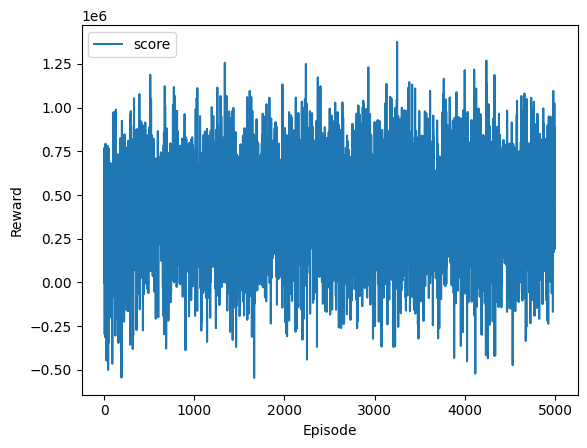

In [ ]:
# TRANING
q_table, bins = Qtable(2, 3)

Q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 5*10**3, timestep = 1000)

### 참고) 차익 계산


In [ ]:
# 차익 계산 코드
data = [{'action': 1, 'price': 38229000, 'time': '2023-05-03T17:21:00+00:00'}, {'action': 2, 'price': 38238000, 'time': '2023-05-03T17:23:00+00:00'}, {'action': 1, 'price': 38372000, 'time': '2023-05-03T17:24:00+00:00'}, {'action': 2, 'price': 38391000, 'time': '2023-05-03T17:28:00+00:00'}, {'action': 1, 'price': 38365000, 'time': '2023-05-03T17:29:00+00:00'}, {'action': 2, 'price': 38369000, 'time': '2023-05-03T17:31:00+00:00'}, {'action': 1, 'price': 38316000, 'time': '2023-05-03T17:33:00+00:00'}, {'action': 2, 'price': 38341000, 'time': '2023-05-03T17:36:00+00:00'}, {'action': 1, 'price': 38369000, 'time': '2023-05-03T17:37:00+00:00'}, {'action': 2, 'price': 38450000, 'time': '2023-05-03T17:40:00+00:00'}, {'action': 1, 'price': 38520000, 'time': '2023-05-03T17:41:00+00:00'}, {'action': 2, 'price': 38541000, 'time': '2023-05-03T17:42:00+00:00'}, {'action': 1, 'price': 38498000, 'time': '2023-05-03T17:43:00+00:00'}, {'action': 2, 'price': 38495000, 'time': '2023-05-03T17:44:00+00:00'}, {'action': 1, 'price': 38454000, 'time': '2023-05-03T17:45:00+00:00'}, {'action': 2, 'price': 38364000, 'time': '2023-05-03T17:48:00+00:00'}, {'action': 1, 'price': 38406000, 'time': '2023-05-03T17:50:00+00:00'}, {'action': 2, 'price': 38405000, 'time': '2023-05-03T18:02:00+00:00'}, {'action': 1, 'price': 38341000, 'time': '2023-05-03T18:04:00+00:00'}, {'action': 2, 'price': 38400000, 'time': '2023-05-03T18:17:00+00:00'}, {'action': 1, 'price': 38381000, 'time': '2023-05-03T18:18:00+00:00'}, {'action': 2, 'price': 38383000, 'time': '2023-05-03T18:19:00+00:00'}, {'action': 1, 'price': 38400000, 'time': '2023-05-03T18:20:00+00:00'}, {'action': 2, 'price': 38400000, 'time': '2023-05-03T18:21:00+00:00'}, {'action': 1, 'price': 38399000, 'time': '2023-05-03T18:23:00+00:00'}, {'action': 2, 'price': 38362000, 'time': '2023-05-03T18:26:00+00:00'}, {'action': 1, 'price': 38273000, 'time': '2023-05-03T18:29:00+00:00'}, {'action': 2, 'price': 38238000, 'time': '2023-05-03T18:32:00+00:00'}, {'action': 1, 'price': 38233000, 'time': '2023-05-03T18:34:00+00:00'}, {'action': 2, 'price': 38145000, 'time': '2023-05-03T18:36:00+00:00'}, {'action': 1, 'price': 38113000, 'time': '2023-05-03T18:37:00+00:00'}, {'action': 2, 'price': 38222000, 'time': '2023-05-03T18:45:00+00:00'}, {'action': 1, 'price': 38223000, 'time': '2023-05-03T18:47:00+00:00'}, {'action': 2, 'price': 38228000, 'time': '2023-05-03T18:56:00+00:00'}, {'action': 1, 'price': 38170000, 'time': '2023-05-03T19:02:00+00:00'}, {'action': 2, 'price': 38185000, 'time': '2023-05-03T19:03:00+00:00'}, {'action': 1, 'price': 38084000, 'time': '2023-05-03T19:14:00+00:00'}, {'action': 2, 'price': 38078000, 'time': '2023-05-03T19:15:00+00:00'}, {'action': 1, 'price': 38120000, 'time': '2023-05-03T19:32:00+00:00'}, {'action': 2, 'price': 38150000, 'time': '2023-05-03T19:34:00+00:00'}, {'action': 1, 'price': 38133000, 'time': '2023-05-03T19:35:00+00:00'}, {'action': 2, 'price': 38101000, 'time': '2023-05-03T19:36:00+00:00'}, {'action': 1, 'price': 38142000, 'time': '2023-05-03T19:38:00+00:00'}, {'action': 2, 'price': 38092000, 'time': '2023-05-03T19:49:00+00:00'}, {'action': 1, 'price': 38132000, 'time': '2023-05-03T19:50:00+00:00'}, {'action': 2, 'price': 38137000, 'time': '2023-05-03T19:52:00+00:00'}, {'action': 1, 'price': 38117000, 'time': '2023-05-03T20:01:00+00:00'}, {'action': 2, 'price': 38147000, 'time': '2023-05-03T20:05:00+00:00'}, {'action': 1, 'price': 38271000, 'time': '2023-05-03T20:11:00+00:00'}, {'action': 2, 'price': 38272000, 'time': '2023-05-03T20:13:00+00:00'}, {'action': 1, 'price': 38276000, 'time': '2023-05-03T20:19:00+00:00'}, {'action': 2, 'price': 38247000, 'time': '2023-05-03T20:20:00+00:00'}, {'action': 1, 'price': 38156000, 'time': '2023-05-03T20:36:00+00:00'}, {'action': 2, 'price': 38130000, 'time': '2023-05-03T20:39:00+00:00'}, {'action': 1, 'price': 38150000, 'time': '2023-05-03T20:44:00+00:00'}, {'action': 2, 'price': 38150000, 'time': '2023-05-03T20:46:00+00:00'}, {'action': 1, 'price': 38150000, 'time': '2023-05-03T20:47:00+00:00'}, {'action': 2, 'price': 38183000, 'time': '2023-05-03T20:50:00+00:00'}, {'action': 1, 'price': 38282000, 'time': '2023-05-03T20:51:00+00:00'}, {'action': 2, 'price': 38294000, 'time': '2023-05-03T20:54:00+00:00'}, {'action': 1, 'price': 38333000, 'time': '2023-05-03T21:02:00+00:00'}, {'action': 2, 'price': 38356000, 'time': '2023-05-03T21:03:00+00:00'}, {'action': 1, 'price': 38338000, 'time': '2023-05-03T21:04:00+00:00'}, {'action': 2, 'price': 38358000, 'time': '2023-05-03T21:11:00+00:00'}, {'action': 1, 'price': 38531000, 'time': '2023-05-03T21:18:00+00:00'}, {'action': 2, 'price': 38495000, 'time': '2023-05-03T21:19:00+00:00'}, {'action': 1, 'price': 38790000, 'time': '2023-05-03T21:21:00+00:00'}, {'action': 2, 'price': 38773000, 'time': '2023-05-03T21:26:00+00:00'}, {'action': 1, 'price': 38729000, 'time': '2023-05-03T21:40:00+00:00'}, {'action': 2, 'price': 38758000, 'time': '2023-05-03T21:41:00+00:00'}, {'action': 1, 'price': 38806000, 'time': '2023-05-03T21:42:00+00:00'}, {'action': 2, 'price': 38767000, 'time': '2023-05-03T21:47:00+00:00'}, {'action': 1, 'price': 38753000, 'time': '2023-05-03T21:48:00+00:00'}, {'action': 2, 'price': 38777000, 'time': '2023-05-03T21:51:00+00:00'}, {'action': 1, 'price': 38802000, 'time': '2023-05-03T21:53:00+00:00'}, {'action': 2, 'price': 38813000, 'time': '2023-05-03T21:54:00+00:00'}, {'action': 1, 'price': 38802000, 'time': '2023-05-03T21:55:00+00:00'}, {'action': 2, 'price': 38679000, 'time': '2023-05-03T21:59:00+00:00'}, {'action': 1, 'price': 38749000, 'time': '2023-05-03T22:00:00+00:00'}, {'action': 2, 'price': 38772000, 'time': '2023-05-03T22:02:00+00:00'}, {'action': 1, 'price': 38766000, 'time': '2023-05-03T22:03:00+00:00'}, {'action': 2, 'price': 38801000, 'time': '2023-05-03T22:06:00+00:00'}, {'action': 1, 'price': 38846000, 'time': '2023-05-03T22:07:00+00:00'}, {'action': 2, 'price': 38962000, 'time': '2023-05-03T22:17:00+00:00'}, {'action': 1, 'price': 38943000, 'time': '2023-05-03T22:18:00+00:00'}, {'action': 2, 'price': 38960000, 'time': '2023-05-03T22:23:00+00:00'}, {'action': 1, 'price': 39041000, 'time': '2023-05-03T22:25:00+00:00'}, {'action': 2, 'price': 39015000, 'time': '2023-05-03T22:26:00+00:00'}, {'action': 1, 'price': 38976000, 'time': '2023-05-03T22:40:00+00:00'}, {'action': 2, 'price': 38994000, 'time': '2023-05-03T22:41:00+00:00'}, {'action': 1, 'price': 38994000, 'time': '2023-05-03T22:42:00+00:00'}, {'action': 2, 'price': 38974000, 'time': '2023-05-03T22:44:00+00:00'}, {'action': 1, 'price': 38970000, 'time': '2023-05-03T22:45:00+00:00'}, {'action': 2, 'price': 38886000, 'time': '2023-05-03T22:47:00+00:00'}, {'action': 1, 'price': 38771000, 'time': '2023-05-03T23:03:00+00:00'}, {'action': 2, 'price': 38730000, 'time': '2023-05-03T23:04:00+00:00'}, {'action': 1, 'price': 38765000, 'time': '2023-05-03T23:09:00+00:00'}, {'action': 2, 'price': 38777000, 'time': '2023-05-03T23:10:00+00:00'}, {'action': 1, 'price': 38831000, 'time': '2023-05-03T23:12:00+00:00'}, {'action': 2, 'price': 38855000, 'time': '2023-05-03T23:24:00+00:00'}, {'action': 1, 'price': 38871000, 'time': '2023-05-03T23:25:00+00:00'}, {'action': 2, 'price': 38762000, 'time': '2023-05-03T23:36:00+00:00'}, {'action': 1, 'price': 38710000, 'time': '2023-05-03T23:43:00+00:00'}, {'action': 2, 'price': 38682000, 'time': '2023-05-03T23:45:00+00:00'}, {'action': 1, 'price': 38702000, 'time': '2023-05-03T23:46:00+00:00'}, {'action': 2, 'price': 38706000, 'time': '2023-05-03T23:49:00+00:00'}]

last_profit = 0
buy_price = 0

for row in data:
    if row['action'] == 1:  # 매수
        buy_price = row['price']
    elif row['action'] == 2 and buy_price != 0:  # 매도
        sell_price = row['price']
        profit = sell_price - buy_price
        last_profit = profit
        buy_price = 0

print("첫 차익:", last_profit)

첫 차익: 4000
